In [14]:
import pandas as pd
import pvlib
import numpy as np 
import matplotlib.pyplot as plt

In [15]:
data = pd.read_csv('resultados.csv') 
data = data.drop(columns='Unnamed: 0')
data['Datetime'] = pd.to_datetime(data['Datetime'])  
display(data)

,Real,Predito,Datetime,Theta,GHI,DNI,DHI
0,15.0,15.0,2019-10-20 00:00:00,0.0,0,0,0
1,15.0,15.0,2019-10-20 00:30:00,0.0,0,0,0
2,15.0,15.0,2019-10-20 01:00:00,0.0,0,0,0
3,15.0,15.0,2019-10-20 01:30:00,0.0,0,0,0
4,15.0,15.0,2019-10-20 02:00:00,0.0,0,0,0
...,...,...,...,...,...,...,...
1435,60.0,15.0,2019-11-18 21:30:00,0.0,0,0,0
1436,15.0,15.0,2019-11-18 22:00:00,0.0,0,0,0
1437,15.0,15.0,2019-11-18 22:30:00,0.0,0,0,0
1438,15.0,15.0,2019-11-18 23:00:00,0.0,0,0,0


In [16]:
latitude = -23.55052
longitude = -46.633308
altitude = 590
albedo = 0.08

In [17]:
def calculate_irradiance(row, angle, latitude, longitude):
    solar_position = pvlib.solarposition.get_solarposition(row['Datetime'], latitude, longitude)
    dni_extra = pvlib.irradiance.get_extra_radiation(row['Datetime'])

    poa_components = pvlib.irradiance.get_total_irradiance(
        surface_tilt=angle,
        surface_azimuth=90,
        dni=row['DNI'],
        ghi=row['GHI'],
        dhi=row['DHI'],
        solar_zenith=solar_position['zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni_extra=dni_extra,
        airmass=pvlib.atmosphere.get_relative_airmass(solar_position['zenith']),
        albedo=albedo
    )
    total_irrad = poa_components['poa_global'].iloc[0] # iloc pega o valor numerico da série
    return total_irrad

In [18]:
irradiancias_IA = []  # Se for inicializada dentro do loop ela é zerada a cada iteração
irradiancias_SPA = []
for i, row in data.iterrows():
  angle = row['Predito'] # Vai pegar somente o angulo especifico de cada linha da iteração
  angle2 = row['Theta']
  irradiance = calculate_irradiance(row, angle, latitude, longitude)
  irradiance2 = calculate_irradiance(row, angle2, latitude, longitude)
  irradiancias_IA.append(irradiance)
  irradiancias_SPA.append(irradiance2)

data['irradiancias IA'] = irradiancias_IA
data['irradiancias SPA'] = irradiancias_SPA
 

In [19]:
display(data)

,Real,Predito,Datetime,Theta,GHI,DNI,DHI,irradiancias IA,irradiancias SPA
0,15.0,15.0,2019-10-20 00:00:00,0.0,0,0,0,0.0,0.0
1,15.0,15.0,2019-10-20 00:30:00,0.0,0,0,0,0.0,0.0
2,15.0,15.0,2019-10-20 01:00:00,0.0,0,0,0,0.0,0.0
3,15.0,15.0,2019-10-20 01:30:00,0.0,0,0,0,0.0,0.0
4,15.0,15.0,2019-10-20 02:00:00,0.0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1435,60.0,15.0,2019-11-18 21:30:00,0.0,0,0,0,0.0,0.0
1436,15.0,15.0,2019-11-18 22:00:00,0.0,0,0,0,0.0,0.0
1437,15.0,15.0,2019-11-18 22:30:00,0.0,0,0,0,0.0,0.0
1438,15.0,15.0,2019-11-18 23:00:00,0.0,0,0,0,0.0,0.0


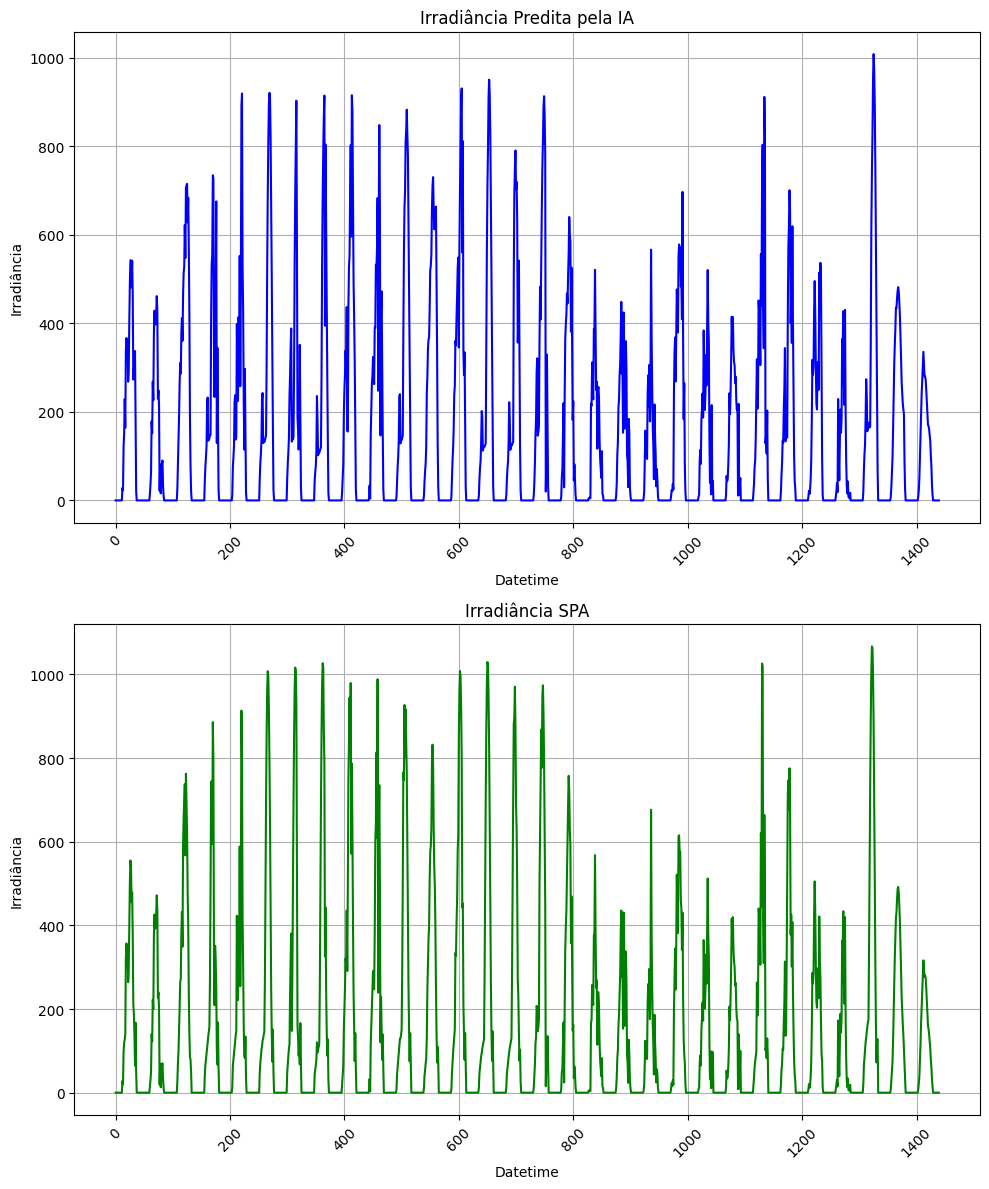

In [23]:
import matplotlib.pyplot as plt

# Criar uma figura com dois subplots (um para cada curva)
plt.figure(figsize=(10, 12))  # Tamanho da figura

# Primeiro subplot para Irradiância IA
plt.subplot(2, 1, 1)  # (número de linhas, número de colunas, índice do plot)
plt.plot(data.index, data['irradiancias IA'], label='Irradiância IA', color='blue')
plt.xlabel('Datetime')
plt.ylabel('Irradiância')
plt.title('Irradiância Predita pela IA')
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Segundo subplot para Irradiância SPA
plt.subplot(2, 1, 2)
plt.plot(data.index, data['irradiancias SPA'], label='Irradiância SPA', color='green')
plt.xlabel('Datetime')
plt.ylabel('Irradiância')
plt.title('Irradiância SPA')
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Exibir os gráficos
plt.show()


In [24]:
from scipy.integrate import trapz
# Agrupar os dados por dia
data['Date'] = data['Datetime'].dt.date
daily_groups = data.groupby('Date')

energia_diaria = {}

# Iterar sobre cada grupo diário e calcular a energia gerada
for date, group in daily_groups:
    # Ordenar os dados por 'Datetime' para garantir a sequência correta de integração
    group = group.sort_values('Datetime')
    
    time_interval_hours = 0.5  # Intervalo de 30 minutos = 0.5 horas
    irradiancia_IA = group['irradiancias IA'].values
    energia_IA = trapz(irradiancia_IA, dx=time_interval_hours)  
    
    irradiancia_SPA = group['irradiancias SPA'].values
    energia_SPA = trapz(irradiancia_SPA, dx=time_interval_hours) 

    energia_diaria[date] = {
        'energia_IA': energia_IA,  
        'energia_SPA': energia_SPA 
    }

for date, energia in energia_diaria.items():
    print(f"Data: {date}, Energia IA: {energia['energia_IA']}, Energia SPA: {energia['energia_SPA']}")


Data: 2019-10-20, Energia IA: 3775.1646915160245, Energia SPA: 3297.3800803244626
Data: 2019-10-21, Energia IA: 2464.564895312333, Energia SPA: 2342.4131245129597
Data: 2019-10-22, Energia IA: 4928.215730520475, Energia SPA: 4526.793089898267
Data: 2019-10-23, Energia IA: 3651.352126831841, Energia SPA: 3634.671202458485
Data: 2019-10-24, Energia IA: 3780.296539026309, Energia SPA: 3337.9706774584974
Data: 2019-10-25, Energia IA: 4607.566142194046, Energia SPA: 4833.979717086244
Data: 2019-10-26, Energia IA: 3577.0509366693964, Energia SPA: 4519.920059973282
Data: 2019-10-27, Energia IA: 4096.011791155955, Energia SPA: 4581.204877745719
Data: 2019-10-28, Energia IA: 4880.4365298832, Energia SPA: 4973.826143081431
Data: 2019-10-29, Energia IA: 4420.609044949756, Energia SPA: 4240.51820565439
Data: 2019-10-30, Energia IA: 4793.971631880954, Energia SPA: 4612.60180292085
Data: 2019-10-31, Energia IA: 5138.411354922091, Energia SPA: 4576.465683203416
Data: 2019-11-01, Energia IA: 5178.9967

C:\Users\Marina\AppData\Local\Temp\ipykernel_12208\3909175886.py:17: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  energia_IA = trapz(irradiancia_IA, dx=time_interval_hours)
C:\Users\Marina\AppData\Local\Temp\ipykernel_12208\3909175886.py:20: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  energia_SPA = trapz(irradiancia_SPA, dx=time_interval_hours)


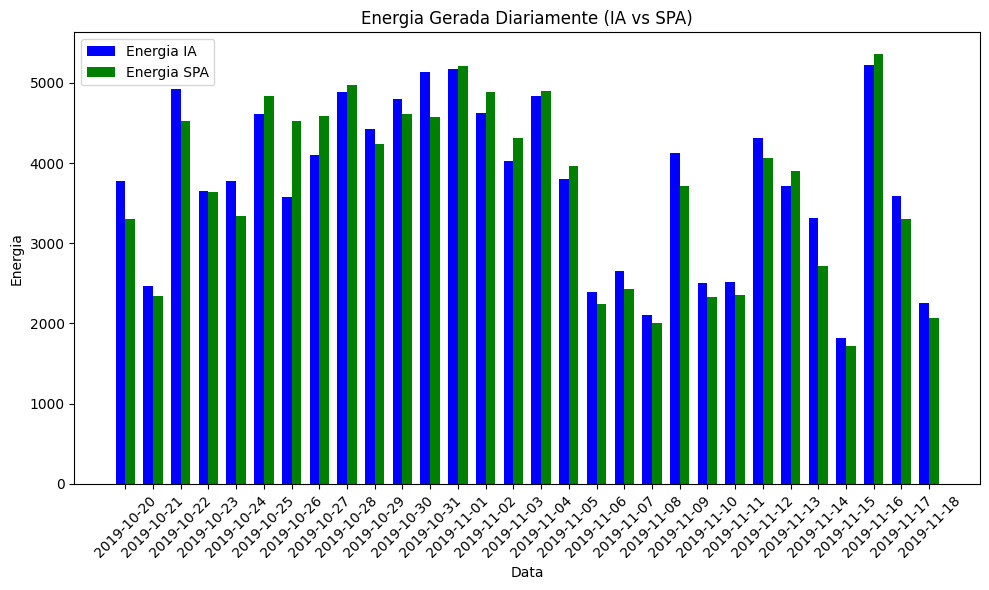

In [25]:
datas = list(energia_diaria.keys())
energia_IA = [energia['energia_IA'] for energia in energia_diaria.values()]
energia_SPA = [energia['energia_SPA'] for energia in energia_diaria.values()]

largura_barras = 0.35
indices = np.arange(len(datas))


plt.figure(figsize=(10, 6))
plt.bar(indices, energia_IA, width=largura_barras, label='Energia IA', color='blue')
plt.bar(indices + largura_barras, energia_SPA, width=largura_barras, label='Energia SPA', color='green')
plt.xlabel('Data')
plt.ylabel('Energia')
plt.title('Energia Gerada Diariamente (IA vs SPA)')
plt.xticks(indices + largura_barras / 2, datas, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


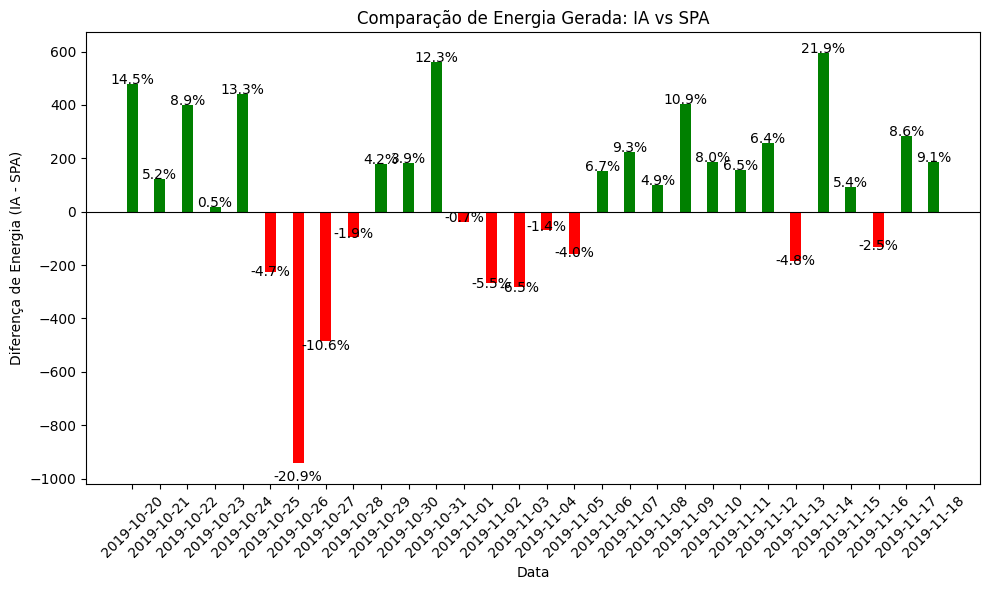

In [42]:
datas = list(energia_diaria.keys())
energia_IA = np.array([energia['energia_IA'] for energia in energia_diaria.values()])
energia_SPA = np.array([energia['energia_SPA'] for energia in energia_diaria.values()])

diff_energia = energia_IA - energia_SPA
percentual_diferenca = (diff_energia / energia_SPA) * 100

indices = np.arange(len(datas))
largura_barras = 0.4


plt.figure(figsize=(10, 6))
cores = ['green' if d > 0 else 'red' for d in diff_energia]
plt.bar(indices, diff_energia, color=cores, width=largura_barras)
plt.xlabel('Data')
plt.ylabel('Diferença de Energia (IA - SPA)')
plt.title('Comparação de Energia Gerada: IA vs SPA')
plt.xticks(indices, datas, rotation=45)
plt.axhline(0, color='black',linewidth=0.8)
for i, (perc, diff) in enumerate(zip(percentual_diferenca, diff_energia)):
    if diff > 0:
        plt.text(i, diff + 0.03, f'{perc:.1f}%', ha='center', color='black')  
    else:
        plt.text(i, diff - 0.07 * abs(diff), f'{perc:.1f}%', ha='center', color='black')    
plt.tight_layout()
plt.show()
